# **Data Exploration**

**Mục tiêu:**  
- Hiểu cấu trúc dữ liệu:
  - Số dòng, số cột, danh sách các features, kiểu dữ liệu.
- Phân tích chất lượng dữ liệu:
  - Missing values, phân phối các biến numeric & categorical.
- Phân tích mối quan hệ giữa các biến với biến mục tiêu `target`.
- Tính toán một số thống kê mô tả & kiểm định giả thuyết đơn giản.
- Rút ra các insight ban đầu để phục vụ:
  - Bước tiền xử lý dữ liệu.
  - Bước xây dựng mô hình dự đoán.

## Import thư viện & thiết lập

In [288]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập style cho biểu đồ
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

sns.set_theme(
    style="whitegrid",
    context="notebook",
    palette="deep"
)

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.edgecolor": "#333333",
    "grid.color": "#DDDDDD",
    "grid.linewidth": 0.7,
    "axes.titleweight": "bold",
    "axes.spines.top": False,
    "axes.spines.right": False
})

# Tăng độ nét hiển thị
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 23120329
np.random.seed(RANDOM_STATE)

# Path
DATA_PATH = "../data/raw/aug_train.csv"

## Tải dữ liệu

In [289]:
# Header
with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

# Data
data = np.genfromtxt(DATA_PATH, delimiter=",", dtype=str, skip_header=1)

## Thông tin cơ bản

### Số dòng & số cột

In [290]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Số dòng: {num_rows}.")
print(f"Số cột : {num_cols}.")

Số dòng: 19158.
Số cột : 14.


### Danh sách Features & Ý nghĩa

In [291]:
print("Danh sách features:")
for i, col in enumerate(header):
    print(f"  {i + 1:2d}. {col}")

Danh sách features:
   1. enrollee_id
   2. city
   3. city_development_index
   4. gender
   5. relevent_experience
   6. enrolled_university
   7. education_level
   8. major_discipline
   9. experience
  10. company_size
  11. company_type
  12. last_new_job
  13. training_hours
  14. target


### Ý nghĩa
- **enrollee_id** — ID ứng viên (unique identifier).
- **city** — mã thành phố ứng viên sinh sống.
- **city_development_index** — mức độ phát triển của thành phố (0–1).
- **gender** — giới tính của ứng viên.
- **relevent_experience** — ứng viên có kinh nghiệm liên quan hay không.
- **enrolled_university** — ứng viên đang theo học loại chương trình đại học nào.
- **education_level** — trình độ học vấn cao nhất.
- **major_discipline** — chuyên ngành học.
- **experience** — số năm kinh nghiệm làm việc.
- **company_size** — quy mô công ty nơi ứng viên làm việc.
- **company_type** — loại hình doanh nghiệp.
- **last_new_job** — số năm kể từ công việc trước.
- **training_hours** — số giờ đào tạo đã hoàn thành.
- **target** — 1 nếu ứng viên muốn đổi việc; 0 nếu không.

## Kiểm tra kiểu dữ liệu

### Helper functions

In [292]:
MISSING_TOKENS = {"", "nan", "NaN", "NULL", "null", "NA"}

def is_missing(x: str) -> bool:
    """Kiểm tra một giá trị có được xem là missing hay không."""
    return x in MISSING_TOKENS

def is_float(x: str) -> bool:
    """Thử convert string sang float, trả về True/False."""
    try:
        float(x)
        return True
    except:
        return False

# Map tên cột -> index, giúp truy xuất cột nhanh
col_idx_map = {name: idx for idx, name in enumerate(header)}

def get_col(col_name: str) -> np.ndarray:
    """Lấy cột dữ liệu dạng np.array[str] theo tên."""
    return data[:, col_idx_map[col_name]]


### Phân loại

In [293]:
numeric_cols = []
categorical_cols = []

for j in range(num_cols):
    col_data = data[:, j]

    # Bỏ missing để đánh giá kiểu dữ liệu
    non_missing = np.array([x for x in col_data if not is_missing(x)])
    if len(non_missing) == 0:
        # Nếu toàn missing -> tạm xem là categorical
        categorical_cols.append(header[j])
        continue

    # Random sample một số giá trị để đo tỉ lệ parse được sang float
    sample_size = min(30, len(non_missing))
    sample = np.random.choice(non_missing, size=sample_size, replace=False)

    numeric_ratio = np.mean([is_float(x) for x in sample])

    if numeric_ratio > 0.8:
        numeric_cols.append(header[j])
    else:
        categorical_cols.append(header[j])

print("=== KIỂU DỮ LIỆU (ước lượng từ EDA) ===")
print("Numeric columns:")
for col in numeric_cols:
    print(" -", col)

print("\nCategorical columns:")
for col in categorical_cols:
    print(" -", col)

total = len(numeric_cols) + len(categorical_cols)
print(f"\nTổng numeric    : {len(numeric_cols)}")
print(f"Tổng categorical: {len(categorical_cols)}")


=== KIỂU DỮ LIỆU (ước lượng từ EDA) ===
Numeric columns:
 - enrollee_id
 - city_development_index
 - experience
 - training_hours
 - target

Categorical columns:
 - city
 - gender
 - relevent_experience
 - enrolled_university
 - education_level
 - major_discipline
 - company_size
 - company_type
 - last_new_job

Tổng numeric    : 5
Tổng categorical: 9


## Phân phối biến mục tiêu `target`

Trước khi đi sâu vào các feature khác, ta cần xem:

- Bao nhiêu ứng viên muốn đổi việc (`target=1`)?
- Bao nhiêu ứng viên không muốn đổi việc (`target=0`)?
- Dataset có bị mất cân bằng lớp (class imbalance) hay không?

target=0 : 14381 mẫu (75.07%)
target=1 : 4777 mẫu (24.93%)


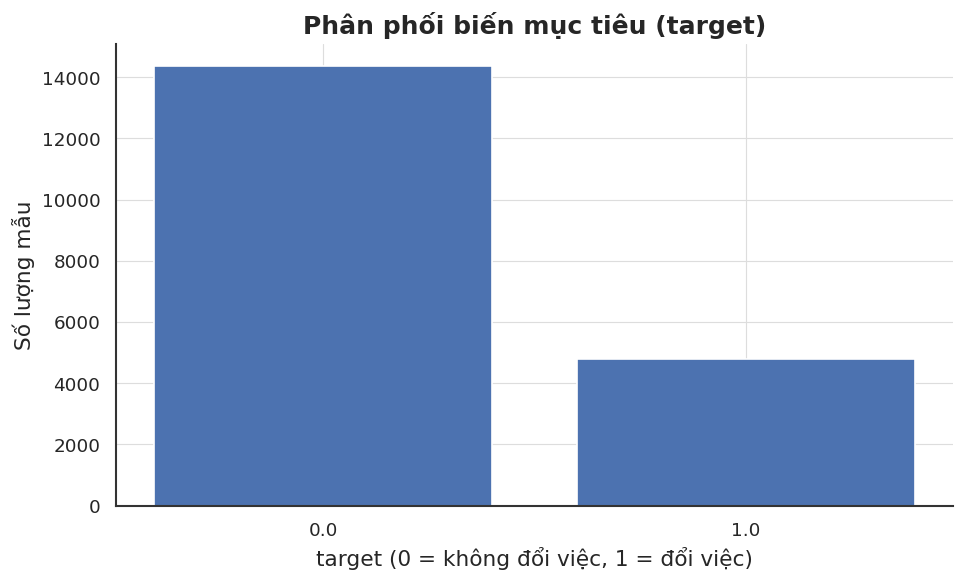

In [294]:
# Chuyển target sang numeric
target = get_col("target").astype(float) 

target_clean = target[~np.isnan(target)]
values, counts = np.unique(target_clean, return_counts=True)

total = counts.sum()
for v, c in zip(values, counts):
    print(f"target={int(v)} : {c} mẫu ({c/total:.2%})")


plt.bar(values.astype(str), counts)
plt.title("Phân phối biến mục tiêu (target)")
plt.xlabel("target (0 = không đổi việc, 1 = đổi việc)")
plt.ylabel("Số lượng mẫu")
plt.show()

## Missing value analysis

In [295]:
missing_counts = np.zeros(num_cols, dtype=int)

for j in range(num_cols):
    col_data = data[:, j]
    missing_counts[j] = np.sum([is_missing(x) for x in col_data])

missing_ratios = missing_counts / num_rows

print("\t======MISSING VALUE THEO CỘT======")
print(f"{'Feature':30s} | {'Missing':>8s} | {'Ratio':>8s}")
print("-" * 55)
for name, cnt, ratio in zip(header, missing_counts, missing_ratios):
    print(f"{name:30s} | {cnt:8d} | {ratio:8.3f}")


	======MISSING VALUE THEO CỘT======
Feature                        |  Missing |    Ratio
-------------------------------------------------------
enrollee_id                    |        0 |    0.000
city                           |        0 |    0.000
city_development_index         |        0 |    0.000
gender                         |     4508 |    0.235
relevent_experience            |        0 |    0.000
enrolled_university            |      386 |    0.020
education_level                |      460 |    0.024
major_discipline               |     2813 |    0.147
experience                     |       65 |    0.003
company_size                   |     5938 |    0.310
company_type                   |     6140 |    0.320
last_new_job                   |      423 |    0.022
training_hours                 |        0 |    0.000
target                         |        0 |    0.000


### Biểu đồ

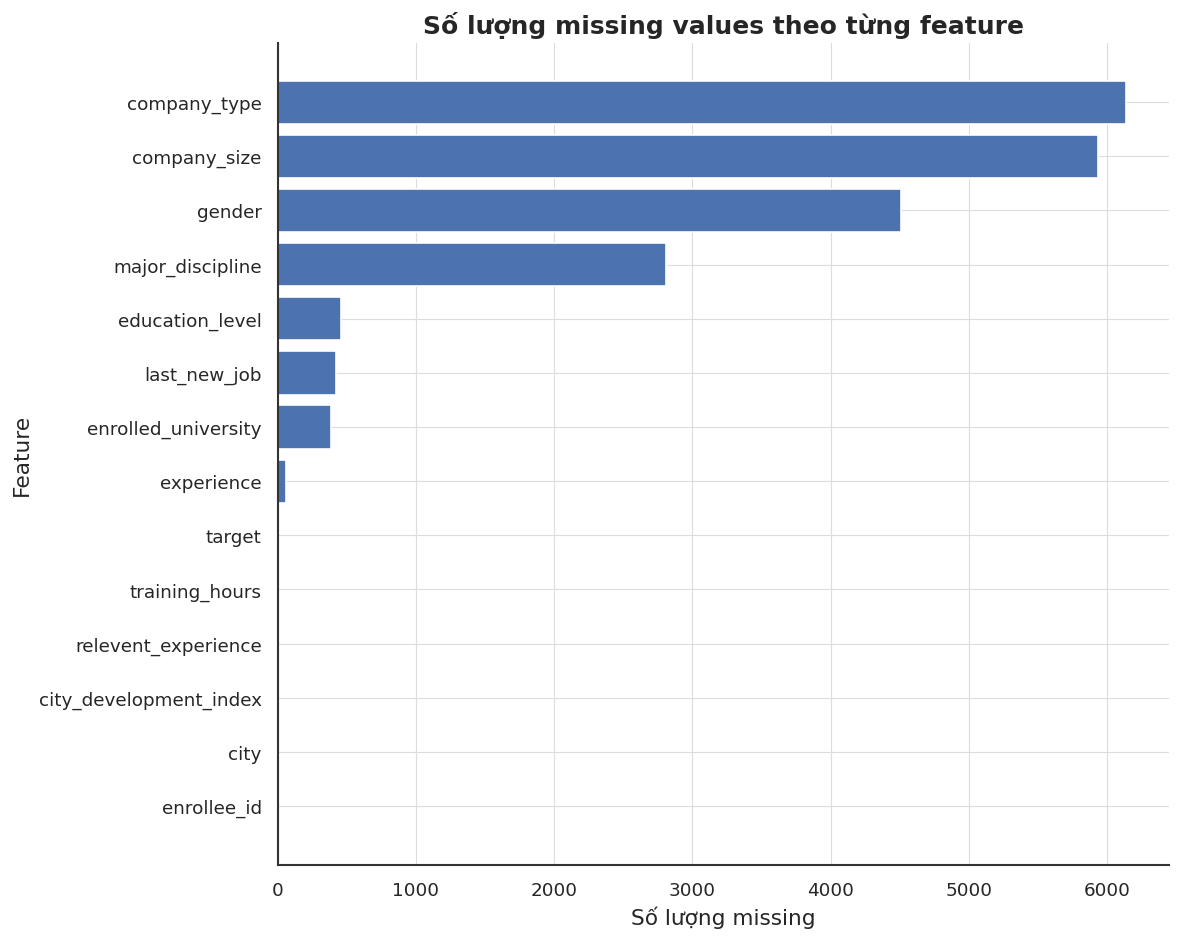

In [296]:
# Sắp xếp theo missing giảm dần 
sorted_idx = np.argsort(missing_counts)[::-1]

features_sorted = np.array(header)[sorted_idx]
missing_sorted = missing_counts[sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(features_sorted, missing_sorted)
plt.title("Số lượng missing values theo từng feature")
plt.xlabel("Số lượng missing")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # để feature nhiều missing nằm trên
plt.show()


## Chuẩn bị các biến numeric cho EDA

In [297]:
def parse_experience(x: str) -> float:
    """
    Chuyển experience từ string sang số năm:
    '<1'  -> 0.0
    '>20' -> 21.0 (hoặc 20.5 tuỳ chọn)
    '5'   -> 5.0
    missing -> np.nan
    """
    if is_missing(x):
        return np.nan
    x = x.strip()
    if x.startswith("<"):
        return 0.0
    if x.startswith(">"):
        return 21.0
    if is_float(x):
        return float(x)
    return np.nan

def get_numeric_array(col_name: str, parser=float) -> np.ndarray:
    """
    Lấy cột col_name và convert về np.array[float], missing -> np.nan.
    """
    col = get_col(col_name)
    out = np.empty(col.shape[0], dtype=float)
    for i, val in enumerate(col):
        try:
            out[i] = parser(val)
        except:
            out[i] = np.nan
    return out

# Các biến numeric chính
cdi = get_numeric_array("city_development_index", parser=float)
training_hours = get_numeric_array("training_hours", parser=float)
experience = get_numeric_array("experience", parser=parse_experience)

print("city_development_index:",
      "mean =", np.nanmean(cdi),
      "| min =", np.nanmin(cdi),
      "| max =", np.nanmax(cdi))

print("training_hours:",
      "mean =", np.nanmean(training_hours),
      "| min =", np.nanmin(training_hours),
      "| max =", np.nanmax(training_hours))

print("experience (years):",
      "mean =", np.nanmean(experience),
      "| min =", np.nanmin(experience),
      "| max =", np.nanmax(experience))


city_development_index: mean = 0.8288480008351603 | min = 0.44799999999999995 | max = 0.9490000000000001
training_hours: mean = 65.36689633573442 | min = 1.0 | max = 336.0
experience (years): mean = 10.100141413083328 | min = 0.0 | max = 21.0


## Thống kê mô tả cho các biến numeric

Ta tính các giá trị:
- mean, std, min, 25%, 50%, 75%, max


In [298]:
numeric_arrays = {
    "city_development_index": cdi,
    "training_hours": training_hours,
    "experience": experience,
}

print(f"{'Feature':25s} | {'mean':>8s} | {'std':>8s} | {'min':>8s} | {'25%':>8s} | {'50%':>8s} | {'75%':>8s} | {'max':>8s}")
print("-" * 90)

for name, arr in numeric_arrays.items():
    x = arr[~np.isnan(arr)]
    q25, q50, q75 = np.percentile(x, [25, 50, 75])
    print(f"{name:25s} | {np.mean(x):8.3f} | {np.std(x):8.3f} | {np.min(x):8.3f} | {q25:8.3f} | {q50:8.3f} | {q75:8.3f} | {np.max(x):8.3f}")


Feature                   |     mean |      std |      min |      25% |      50% |      75% |      max
------------------------------------------------------------------------------------------
city_development_index    |    0.829 |    0.123 |    0.448 |    0.740 |    0.903 |    0.920 |    0.949
training_hours            |   65.367 |   60.057 |    1.000 |   23.000 |   47.000 |   88.000 |  336.000
experience                |   10.100 |    6.777 |    0.000 |    4.000 |    9.000 |   16.000 |   21.000


### Vẽ histogram + boxplot

In [299]:
def plot_hist_box(x: np.ndarray, title: str, bins: int = 30):
    x_clean = x[~np.isnan(x)]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram
    axes[0].hist(x_clean, bins=bins)
    axes[0].set_title(f"Histogram of {title}")
    axes[0].set_xlabel(title)
    axes[0].set_ylabel("Count")

    # Boxplot
    axes[1].boxplot(x_clean, vert=True)
    axes[1].set_title(f"Boxplot of {title}")
    axes[1].set_ylabel(title)

    plt.tight_layout()
    plt.show()


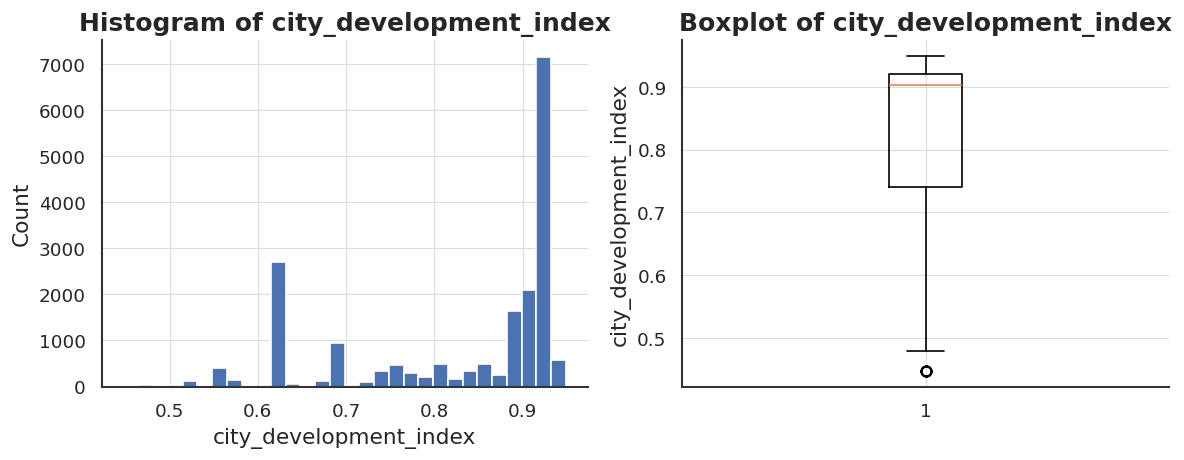

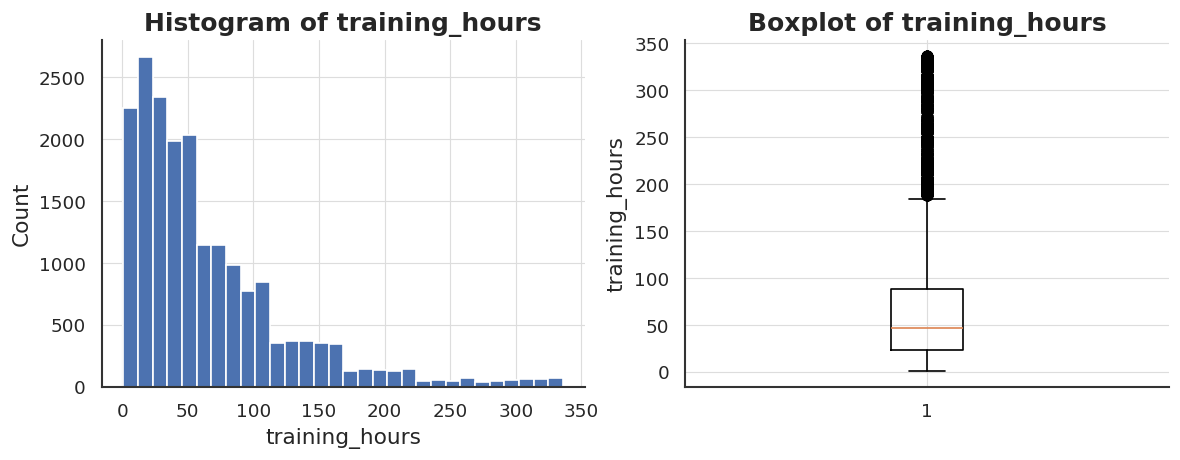

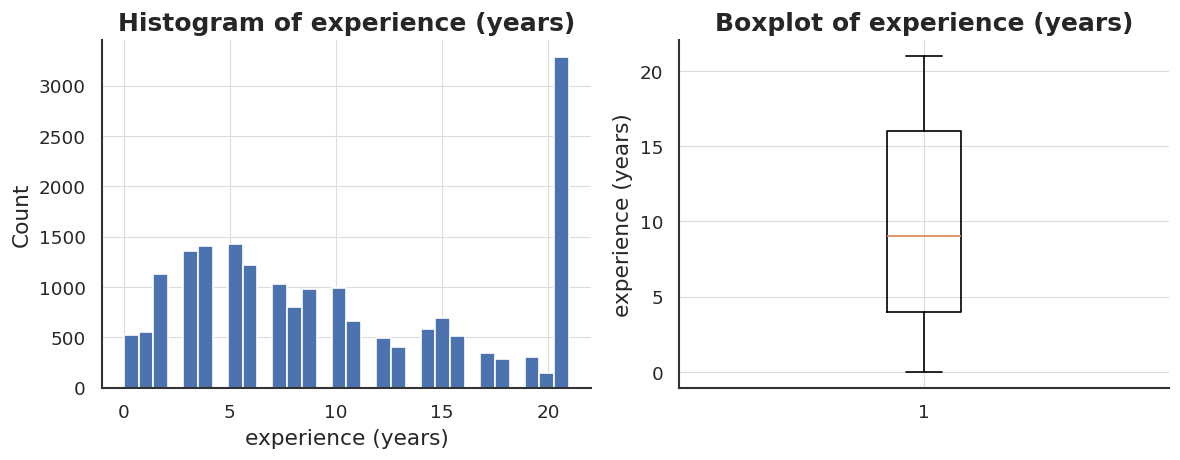

In [300]:
plot_hist_box(cdi, "city_development_index")
plot_hist_box(training_hours, "training_hours")
plot_hist_box(experience, "experience (years)")

## Vẽ phân phối categorical

In [301]:
def plot_categorical(col_name: str, top_k=None):
    """
    Vẽ phân phối cho 1 biến categorical.
    Nếu top_k != None, chỉ vẽ top_k giá trị xuất hiện nhiều nhất.
    """
    col = get_col(col_name)
    # Chuyển toàn bộ về string để tránh lỗi so sánh nan/None
    col = np.array([str(x) if x is not None else '' for x in col])
    
    values, counts = np.unique(col, return_counts=True)

    # Sort giảm dần theo count
    idx_sorted = np.argsort(-counts)
    values = values[idx_sorted]
    counts = counts[idx_sorted]

    if top_k is not None:
        values = values[:top_k]
        counts = counts[:top_k]

    clean_labels = []
    for v in values:
        if not v or str(v).lower() == 'nan':
            clean_labels.append("NOT HAS VALUE") 
        else:
            clean_labels.append(str(v))
    # ------------------------------

    plt.figure(figsize=(8, 4))
    
    plt.bar(clean_labels, counts) 
    
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Phân phối biến categorical: {col_name}")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    print(f"=== Thống kê cho {col_name} ===")
    for label, c in zip(clean_labels, counts):
        print(f"{label:20s} : {c}")
    print()


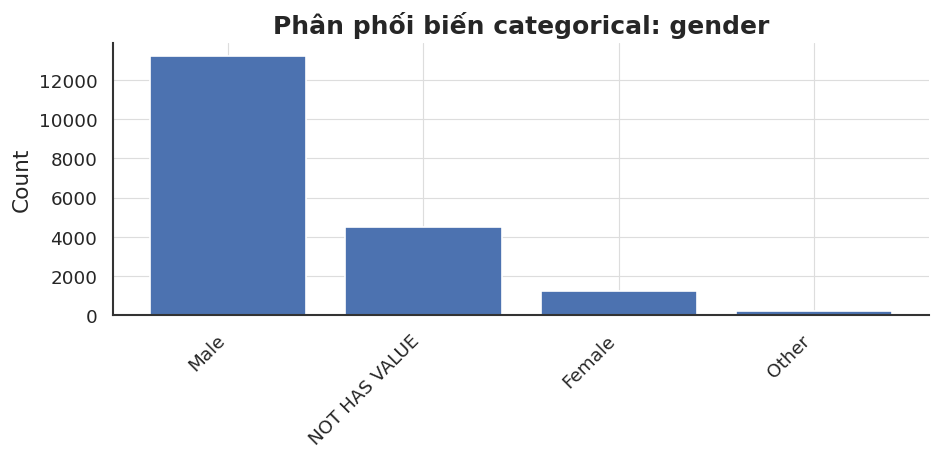

=== Thống kê cho gender ===
Male                 : 13221
NOT HAS VALUE        : 4508
Female               : 1238
Other                : 191



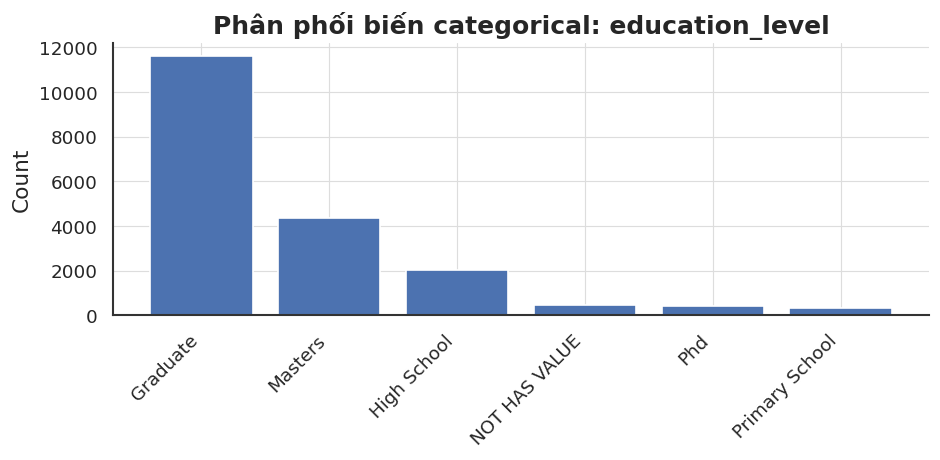

=== Thống kê cho education_level ===
Graduate             : 11598
Masters              : 4361
High School          : 2017
NOT HAS VALUE        : 460
Phd                  : 414
Primary School       : 308



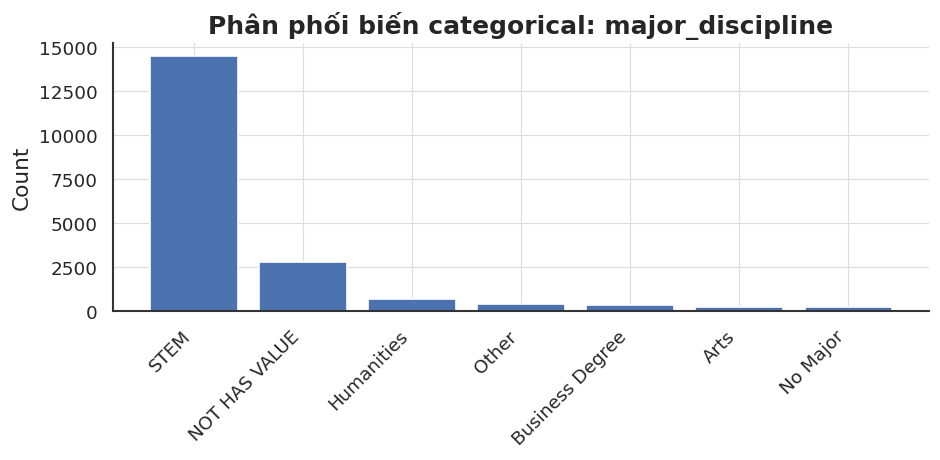

=== Thống kê cho major_discipline ===
STEM                 : 14492
NOT HAS VALUE        : 2813
Humanities           : 669
Other                : 381
Business Degree      : 327
Arts                 : 253
No Major             : 223



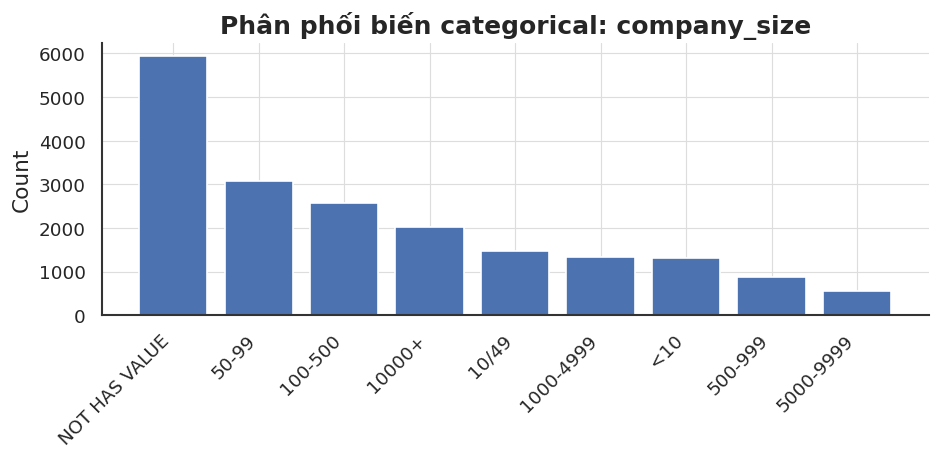

=== Thống kê cho company_size ===
NOT HAS VALUE        : 5938
50-99                : 3083
100-500              : 2571
10000+               : 2019
10/49                : 1471
1000-4999            : 1328
<10                  : 1308
500-999              : 877
5000-9999            : 563



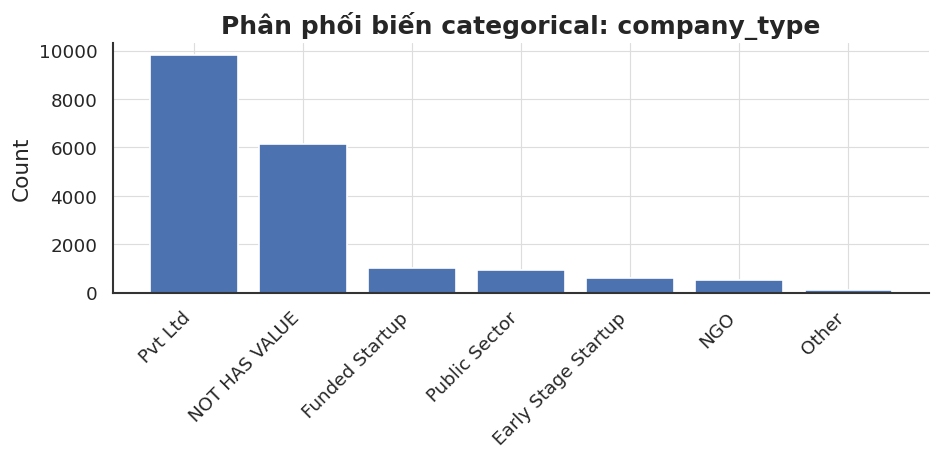

=== Thống kê cho company_type ===
Pvt Ltd              : 9817
NOT HAS VALUE        : 6140
Funded Startup       : 1001
Public Sector        : 955
Early Stage Startup  : 603
NGO                  : 521
Other                : 121



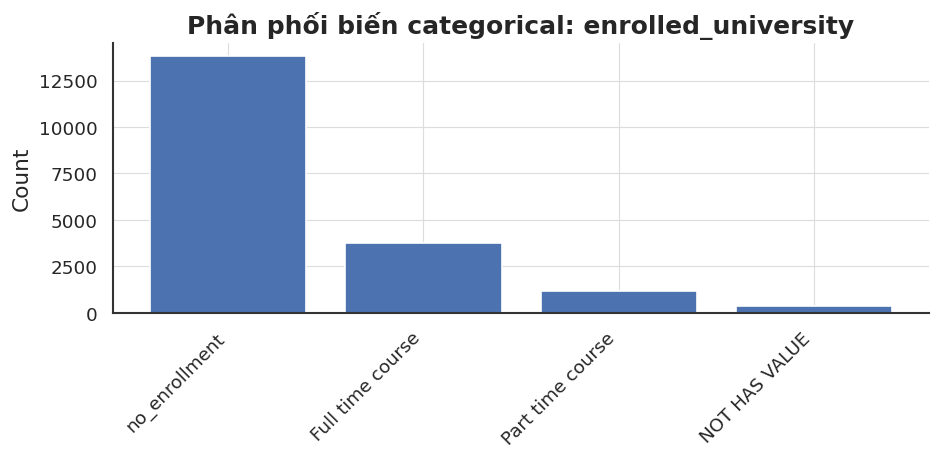

=== Thống kê cho enrolled_university ===
no_enrollment        : 13817
Full time course     : 3757
Part time course     : 1198
NOT HAS VALUE        : 386



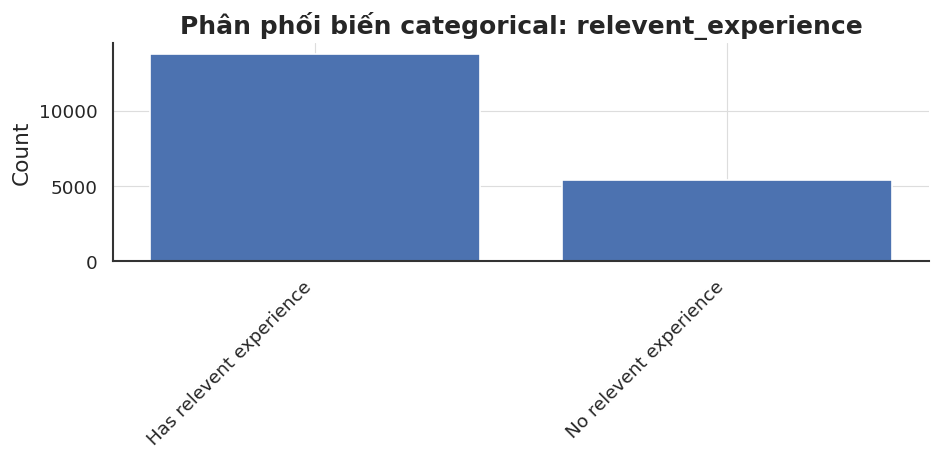

=== Thống kê cho relevent_experience ===
Has relevent experience : 13792
No relevent experience : 5366



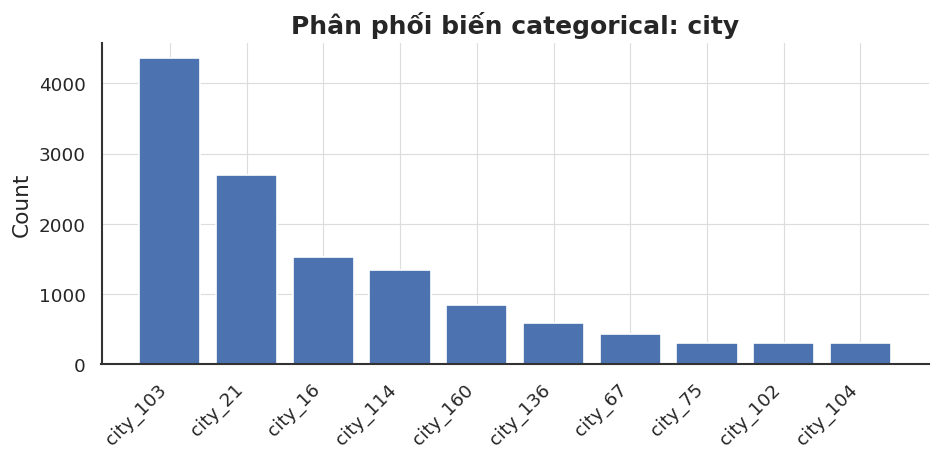

=== Thống kê cho city ===
city_103             : 4355
city_21              : 2702
city_16              : 1533
city_114             : 1336
city_160             : 845
city_136             : 586
city_67              : 431
city_75              : 305
city_102             : 304
city_104             : 301



In [302]:
for cat_col in [
    "gender",
    "education_level",
    "major_discipline",
    "company_size",
    "company_type",
    "enrolled_university",
    "relevent_experience"
]:
    plot_categorical(cat_col)

# Xem top 10
plot_categorical("city", top_k=10)


## Bivariate: target rate theo từng category

In [303]:
def plot_target_rate_by_category(col_name: str):
    """
    Vẽ bar chart tỉ lệ target=1 theo từng giá trị của biến categorical.
    """
    col = get_col(col_name)
    uniq_vals = np.unique(col)

    rates = []
    counts = []

    for v in uniq_vals:
        mask = (col == v)
        y = target[mask]
        y_clean = y[~np.isnan(y)]
        if len(y_clean) == 0:
            rates.append(np.nan)
            counts.append(0)
        else:
            rates.append(np.mean(y_clean))  # tỉ lệ target=1
            counts.append(len(y_clean))

    rates = np.array(rates)
    counts = np.array(counts)
    uniq_vals = np.array(uniq_vals)

    valid_mask = ~np.isnan(rates)
    rates = rates[valid_mask]
    counts = counts[valid_mask]
    uniq_vals = uniq_vals[valid_mask]

    idx_sorted = np.argsort(-rates)
    rates = rates[idx_sorted]
    counts = counts[idx_sorted]
    uniq_vals = uniq_vals[idx_sorted]

    plt.figure(figsize=(8, 4))
    plt.bar(uniq_vals, rates)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Tỷ lệ target = 1")
    plt.title(f"Tỷ lệ đổi việc theo {col_name}")
    plt.tight_layout()
    plt.show()

    print(f"=== Tỷ lệ target=1 theo {col_name} ===")
    for v, r, c in zip(uniq_vals, rates, counts):
        print(f"{v:20s} | n={c:4d} | rate={r:.3f}")
    print()


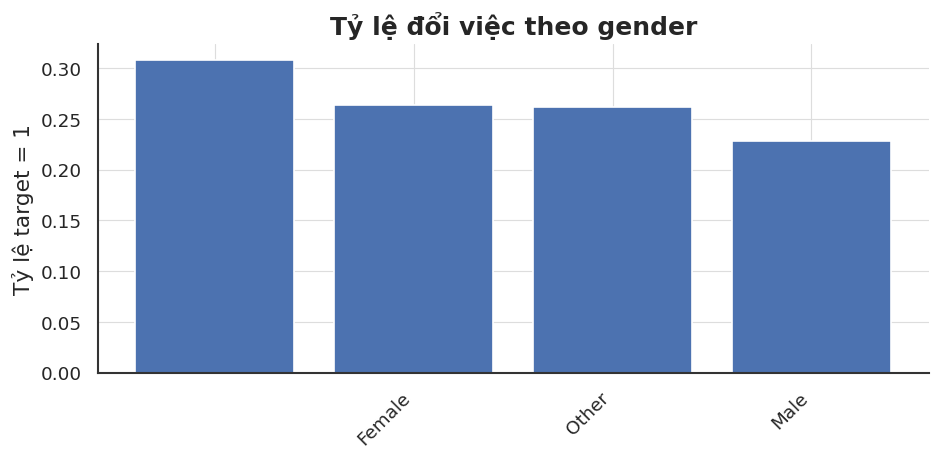

=== Tỷ lệ target=1 theo gender ===
                     | n=4508 | rate=0.308
Female               | n=1238 | rate=0.263
Other                | n= 191 | rate=0.262
Male                 | n=13221 | rate=0.228



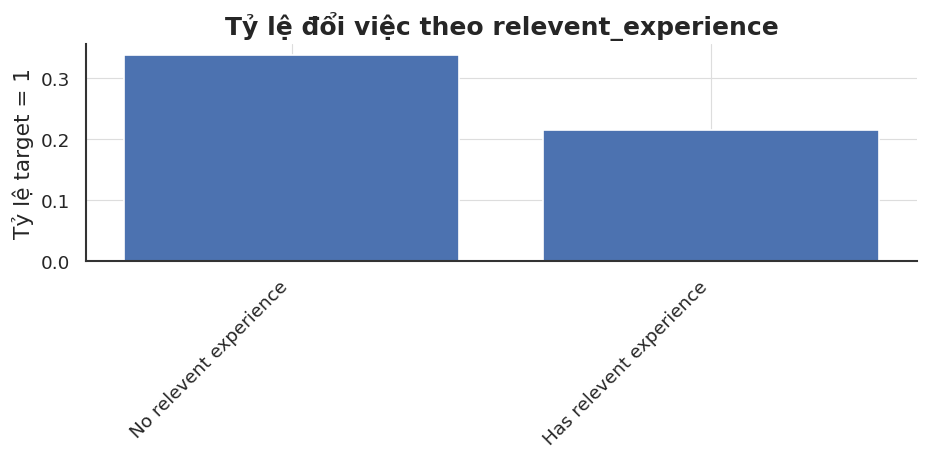

=== Tỷ lệ target=1 theo relevent_experience ===
No relevent experience | n=5366 | rate=0.338
Has relevent experience | n=13792 | rate=0.215



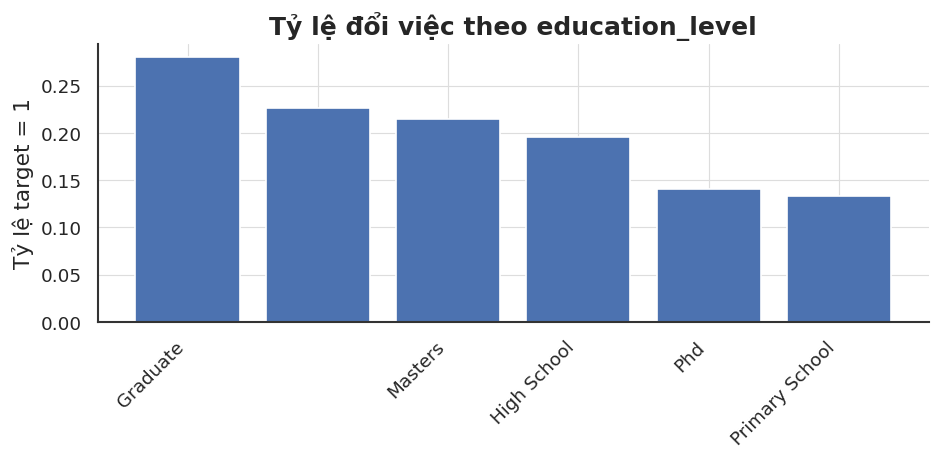

=== Tỷ lệ target=1 theo education_level ===
Graduate             | n=11598 | rate=0.280
                     | n= 460 | rate=0.226
Masters              | n=4361 | rate=0.214
High School          | n=2017 | rate=0.195
Phd                  | n= 414 | rate=0.140
Primary School       | n= 308 | rate=0.133



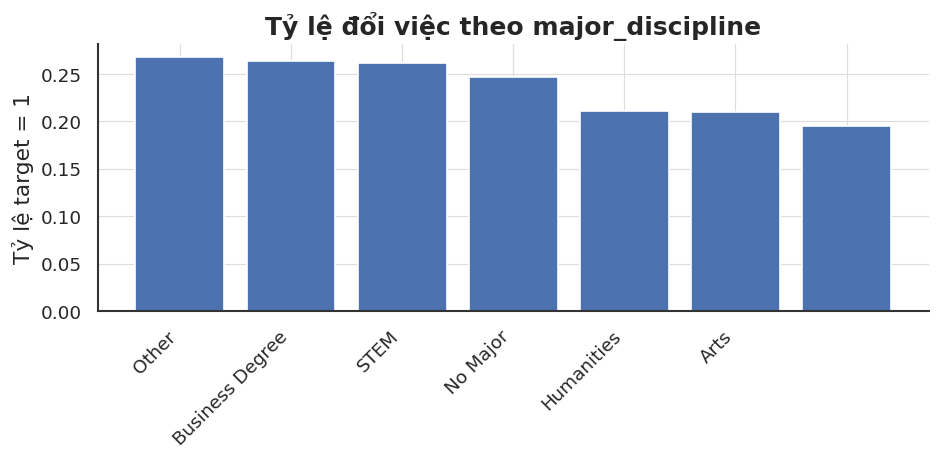

=== Tỷ lệ target=1 theo major_discipline ===
Other                | n= 381 | rate=0.268
Business Degree      | n= 327 | rate=0.263
STEM                 | n=14492 | rate=0.262
No Major             | n= 223 | rate=0.247
Humanities           | n= 669 | rate=0.211
Arts                 | n= 253 | rate=0.209
                     | n=2813 | rate=0.195



In [304]:
for col_name in ["gender", "relevent_experience", "education_level", "major_discipline"]:
    plot_target_rate_by_category(col_name)


## Bivariate: boxplot numeric vs target

In [305]:
def boxplot_numeric_by_target(x: np.ndarray, x_name: str):
    """Vẽ boxplot của 1 biến numeric cho 2 nhóm target=0 và target=1."""
    mask0 = (target == 0)
    mask1 = (target == 1)

    x0 = x[mask0]
    x1 = x[mask1]

    x0 = x0[~np.isnan(x0)]
    x1 = x1[~np.isnan(x1)]

    plt.figure(figsize=(6, 4))
    plt.boxplot([x0, x1], labels=["target=0", "target=1"])
    plt.title(f"{x_name} theo target")
    plt.ylabel(x_name)
    plt.show()

    print(f"=== Thống kê {x_name} theo target ===")
    print("target=0:",
          "mean =", np.mean(x0),
          "| median =", np.median(x0),
          "| n =", len(x0))
    print("target=1:",
          "mean =", np.mean(x1),
          "| median =", np.median(x1),
          "| n =", len(x1))
    print()

C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_12820\3745124713.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["target=0", "target=1"])


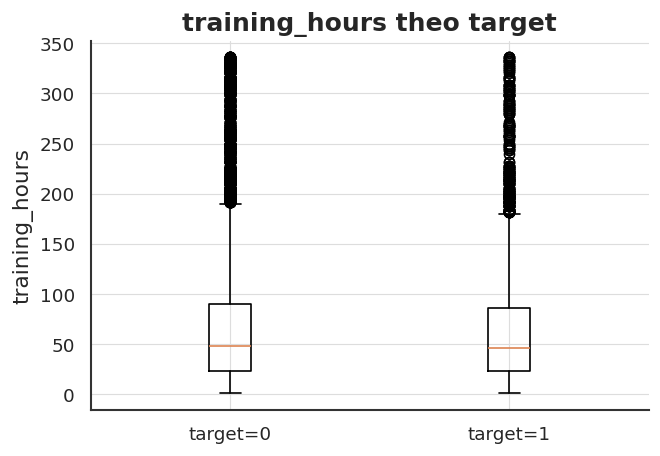

=== Thống kê training_hours theo target ===
target=0: mean = 66.11376121271121 | median = 48.0 | n = 14381
target=1: mean = 63.11848440443793 | median = 46.0 | n = 4777



C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_12820\3745124713.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["target=0", "target=1"])


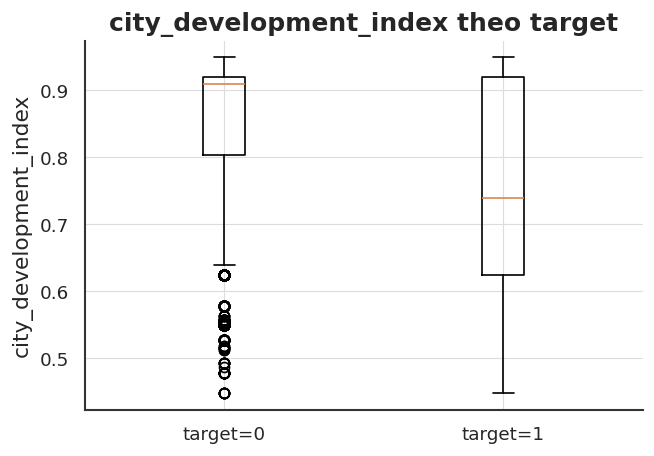

=== Thống kê city_development_index theo target ===
target=0: mean = 0.8531394200681456 | median = 0.91 | n = 14381
target=1: mean = 0.7557194892191752 | median = 0.74 | n = 4777



C:\Users\Phuc Chau\AppData\Local\Temp\ipykernel_12820\3745124713.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x0, x1], labels=["target=0", "target=1"])


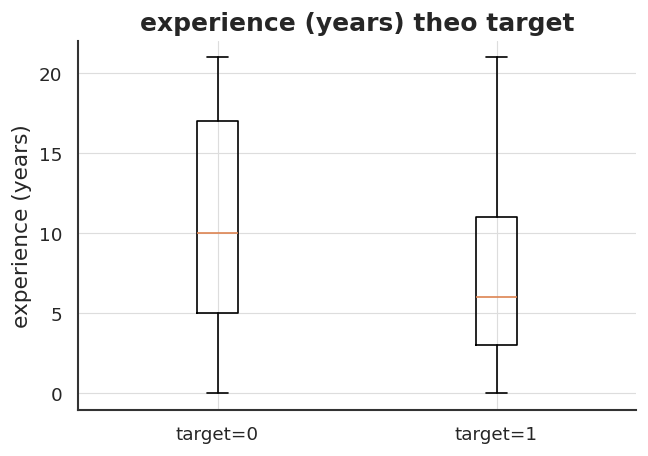

=== Thống kê experience (years) theo target ===
target=0: mean = 10.789734291094218 | median = 10.0 | n = 14339
target=1: mean = 8.020193521245266 | median = 6.0 | n = 4754



In [306]:
boxplot_numeric_by_target(training_hours, "training_hours")
boxplot_numeric_by_target(cdi, "city_development_index")
boxplot_numeric_by_target(experience, "experience (years)")

## Correlation giữa các biến numeric

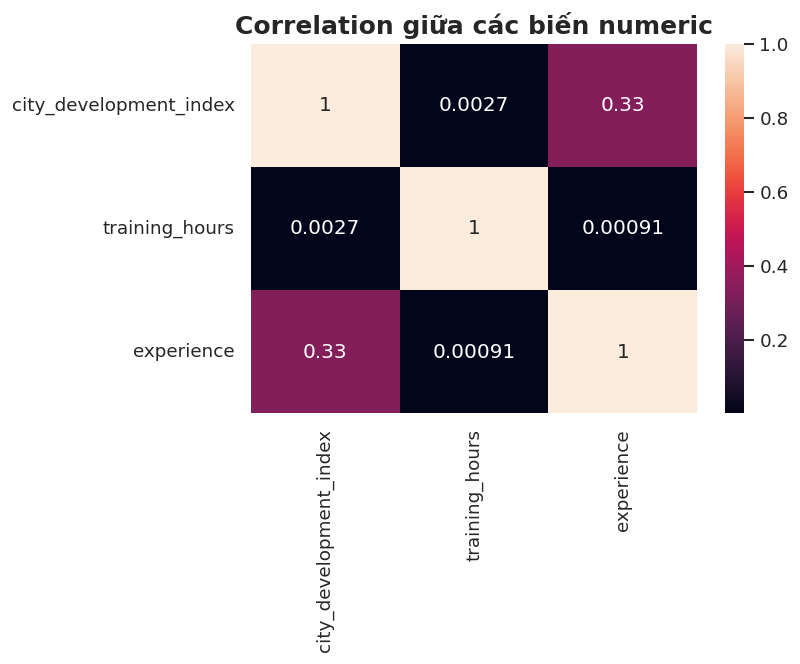

In [307]:
# Ghép các numeric lại thành 1 matrix (drop các dòng có nan đơn giản)
num_matrix = np.vstack([cdi, training_hours, experience]).T
mask_valid = ~np.isnan(num_matrix).any(axis=1)
num_matrix_clean = num_matrix[mask_valid]

corr = np.corrcoef(num_matrix_clean, rowvar=False)

num_feature_names = ["city_development_index", "training_hours", "experience"]

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True,
            xticklabels=num_feature_names,
            yticklabels=num_feature_names)
plt.title("Correlation giữa các biến numeric")
plt.show()


## Kiểm định giả thuyết

Ví dụ: kiểm tra xem số giờ training (`training_hours`) giữa hai nhóm
- Nhóm không đổi việc (`target = 0`)
- Nhóm muốn đổi việc (`target = 1`)

có khác biệt có ý nghĩa thống kê hay không.

**Giả thiết:**

- H0: trung bình `training_hours` của hai nhóm **bằng nhau**.
- H1: trung bình `training_hours` của hai nhóm **khác nhau**.

Vì số lượng mẫu lớn, có thể dùng xấp xỉ phân phối chuẩn để đánh giá độ lớn của t-statistic.


In [308]:
# Tách 2 nhóm
mask0 = (target == 0)
mask1 = (target == 1)

th0 = training_hours[mask0]
th1 = training_hours[mask1]

th0 = th0[~np.isnan(th0)]
th1 = th1[~np.isnan(th1)]

n0, n1 = len(th0), len(th1)
mean0, mean1 = np.mean(th0), np.mean(th1)
var0, var1 = np.var(th0, ddof=1), np.var(th1, ddof=1)  # sample variance

# t-statistic hai mẫu độc lập (Welch's t-test)
se = np.sqrt(var0 / n0 + var1 / n1)
t_stat = (mean0 - mean1) / se

print("=== So sánh training_hours giữa 2 nhóm target ===")
print(f"Nhóm target=0: n={n0}, mean={mean0:.3f}, std={np.std(th0, ddof=1):.3f}")
print(f"Nhóm target=1: n={n1}, mean={mean1:.3f}, std={np.std(th1, ddof=1):.3f}")
print(f"t-statistic  : {t_stat:.3f}")

print("""
Diễn giải:
- |t| càng lớn -> càng có nhiều bằng chứng chống lại H0.
- Với số mẫu lớn, |t| > ~1.96 thường tương ứng p-value < 0.05
  (mức ý nghĩa 5%), ta có thể xem như có khác biệt đáng kể.
""")


=== So sánh training_hours giữa 2 nhóm target ===
Nhóm target=0: n=14381, mean=66.114, std=60.939
Nhóm target=1: n=4777, mean=63.118, std=57.274
t-statistic  : 3.081

Diễn giải:
- |t| càng lớn -> càng có nhiều bằng chứng chống lại H0.
- Với số mẫu lớn, |t| > ~1.96 thường tương ứng p-value < 0.05
  (mức ý nghĩa 5%), ta có thể xem như có khác biệt đáng kể.



## Câu hỏi EDA & Trả lời (Q&A)

Dưới đây là một số câu hỏi gợi ý mà ta có thể trả lời dựa trên các biểu đồ & số liệu ở trên:

**Q1. Tỷ lệ ứng viên muốn đổi việc là bao nhiêu? Dataset có mất cân bằng lớp không?**  
→ Dựa trên phân phối `target`, ta thấy `target=1` chiếm khoảng ...%, `target=0` chiếm khoảng ...%.
Điều này cho thấy (có/không) có vấn đề class imbalance cần chú ý ở bước modeling.

**Q2. Ứng viên có kinh nghiệm liên quan (`relevent_experience`) có xu hướng muốn đổi việc nhiều hơn hay ít hơn?**  
→ Từ biểu đồ tỷ lệ target theo `relevent_experience`, ta thấy nhóm ... có tỷ lệ `target=1` là ...,
cao hơn nhóm ... khoảng ... điểm %. Điều này gợi ý rằng ...

**Q3. Số năm kinh nghiệm (`experience`) ảnh hưởng thế nào đến việc đổi việc?**  
→ Từ boxplot `experience` theo `target`, có thể thấy nhóm `target=1` có median ~..., trong khi nhóm `target=0` khoảng ~...
Điều này cho thấy những người (ít / nhiều) kinh nghiệm có xu hướng đổi việc nhiều hơn.

**Q4. Các nhóm trình độ học vấn (`education_level`) nào có tỷ lệ đổi việc cao hơn?**  
→ Dựa vào biểu đồ `education_level` vs. target, nhóm ... có tỷ lệ đổi việc cao nhất (~...%), trong khi nhóm ... thấp hơn (~...%).

**Q5. Số giờ đào tạo (`training_hours`) có vai trò gì?**  
→ Từ boxplot và kiểm định t-test, mean của `training_hours` ở nhóm `target=1` là ..., ở nhóm `target=0` là ...
Nếu |t| > 1.96, ta có thể coi sự khác biệt này là có ý nghĩa thống kê ở mức ~5%.
Điều này gợi ý rằng những người tham gia training nhiều hơn có xu hướng ...

---

## Summary & Insights

Tóm tắt một số điểm chính (viết lại bằng số liệu cụ thể):

- Tỷ lệ ứng viên muốn đổi việc (`target=1`) khoảng ~...%.
- Các yếu tố có vẻ liên quan mạnh đến quyết định đổi việc:
  - Kinh nghiệm liên quan (`relevent_experience`),
  - Số năm kinh nghiệm (`experience`),
  - Số giờ training (`training_hours`),
  - Trình độ học vấn (`education_level`), chuyên ngành (`major_discipline`).

Những kết quả này sẽ được dùng để:
- Định nghĩa chiến lược xử lý missing values & mã hóa dữ liệu ở notebook 02 (preprocessing).
- Ưu tiên lựa chọn các feature quan trọng cho notebook 03 (modeling).
